### data2a - 120416_0229
* re-run, trying regularization

### data2a - 120116_1200
* run with cleaned dataset, just on damage location, 256x256, ft 8 batch size, 88s per epoch, theano backend
* saved history, created metrics plots
* noted that rmsprop results in higher top layer accuracy for initial fit - closer to 70%
* loss: 0.6640 - acc: 0.7273 - val_loss: 0.5893 - val_acc: 0.7836

### data2 - 112916_1200
* run without discards, just on damage location 256x256, 16 batch size, 80s per epoch, theano backend
* loss: 0.6776 - acc: 0.7151 - val_loss: 0.7998 - val_acc: 0.6928

In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [3]:
import os
import h5py
import numpy as np
import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras import Model

# only import if using tf backend
# import tensorflow as tf
# tf.python.control_flow_ops = tf

In [3]:
def load_vgg16(crop=True, weights_path='../vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
      
    # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 

        f = h5py.File(weights_path)
        for k in range(f.attrs['nb_layers']):
            if k >= len(model.layers): 
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [13]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    model.summary()
    
    #model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=11,
                                            class_mode=None,
                                            shuffle=False)
    
    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=9,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [5]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [6]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout()
    
    print("Best Model:") 
    print_best_model_results(hist)

In [56]:
# load saved data and train a small, fully-connected model
def train_categorical_model():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax')) # upped to 3 and activation softmax

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
    
    # optimizer='rmsprop'
    # optimizers.SGD(lr=0.0001, momentum=0.9)
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=1,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [58]:
def finetune_categorical_model():
    # model = load_vgg16()
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    # add the model on top of the convolutional base
    
    model.summary()
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:19]:
        layer.trainable=False


    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=1,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=1,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit(train_generator,
                        steps_per_epoch=nb_train_samples,
                        epochs=nb_epoch,
                        batch_size=1,
                        validation_data=validation_generator,
                        validation_steps=nb_validation_samples,
                        validation_batch_size=1,
                        verbose=1,
                        callbacks=[checkpoint])
    
    with open(location+'/history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [67]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=11,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print()
    print(classification_report(validation_labels, pred_labels))
    print()
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True);

In [68]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Inputs

In [12]:
# path to the model weights file
location = 'car-damage-dataset/data2a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
print(nb_train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)
print(nb_validation_samples)

nb_epoch = 50

979
171


In [32]:
d2_model, d2_history = train_categorical_model()

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
89/89 [==============================] - ETA: 0s - loss: 6.3665 - accuracy: 0.3830WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x16d4df040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=

89/89 [==============================] - 2s 24ms/step - loss: 5.8182 - accuracy: 0.6982 - val_loss: 5.8770 - val_accuracy: 0.6608

Epoch 00030: val_accuracy did not improve from 0.66082
Epoch 31/50
89/89 [==============================] - 2s 24ms/step - loss: 5.8956 - accuracy: 0.6358 - val_loss: 5.9766 - val_accuracy: 0.5731

Epoch 00031: val_accuracy did not improve from 0.66082
Epoch 32/50
89/89 [==============================] - 2s 24ms/step - loss: 5.8239 - accuracy: 0.7034 - val_loss: 5.9123 - val_accuracy: 0.5965

Epoch 00032: val_accuracy did not improve from 0.66082
Epoch 33/50
89/89 [==============================] - 2s 24ms/step - loss: 5.8153 - accuracy: 0.6992 - val_loss: 5.8767 - val_accuracy: 0.6550

Epoch 00033: val_accuracy did not improve from 0.66082
Epoch 34/50
89/89 [==============================] - 2s 24ms/step - loss: 5.8502 - accuracy: 0.6830 - val_loss: 5.8669 - val_accuracy: 0.6550

Epoch 00034: val_accuracy did not improve from 0.66082
Epoch 35/50
89/89 [===

In [9]:
ft_d2_model, ft_d2_history = finetune_v2_model()

Model with partial VGG16 weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
979/979 [==============================] - 89s - loss: 1.7468 - acc: 0.5506 - val_loss: 0.9886 - val_acc: 0.6901
Epoch 2/50
979/979 [==============================] - 88s - loss: 1.1734 - acc: 0.5352 - val_loss: 0.7967 - val_acc: 0.6433
Epoch 3/50
979/979 [==============================] - 88s - loss: 1.0206 - acc: 0.5781 - val_loss: 0.8533 - val_acc: 0.6491
Epoch 4/50
979/979 [==============================] - 89s - loss: 0.9206 - acc: 0.6108 - val_loss: 0.8348 - val_acc: 0.6959
Epoch 5/50
979/979 [==============================] - 89s - loss: 0.9411 - acc: 0.5873 - val_loss: 0.8414 - val_acc: 0.7251
Epoch 6/50
979/979 [==============================] - 88s - loss: 0.9164 - acc: 0.5955 - val_loss: 0.8988 - val_acc: 0.6316
Epoch 7/50
979/979 [==============================] - 88s - loss: 0.8667 - acc: 0.6251 - val_loss: 0.8640 - val_acc: 0.6257
Epoch 8/5

Try:
* more aggresive data augmentation
* more aggressive dropout
* use of L1 and L2 regularization (also known as "weight decay")
* fine-tuning one more convolutional block (alongside greater regularization)
* use  LR reduce callback
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

### Second Run - With Regularization

In [14]:
# do not rerun!!
save_bottleneck_features(location)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

2022-02-03 14:57:16.593706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-03 14:57:16.593933: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Found 171 images belonging to 3 classes.


In [57]:
d2_model, d2_history = train_categorical_model()

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
979/979 [==============================] - ETA: 0s - loss: 6.4056 - accuracy: 0.3525WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2f3527af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT


Epoch 00029: val_accuracy did not improve from 0.71930
Epoch 30/50
979/979 [==============================] - 18s 18ms/step - loss: 5.3984 - accuracy: 0.8908 - val_loss: 5.9858 - val_accuracy: 0.7018

Epoch 00030: val_accuracy did not improve from 0.71930
Epoch 31/50
979/979 [==============================] - 18s 18ms/step - loss: 5.3577 - accuracy: 0.9077 - val_loss: 5.9650 - val_accuracy: 0.7251

Epoch 00031: val_accuracy improved from 0.71930 to 0.72515, saving model to car-damage-dataset/data2a/top_model_weights.h5
Epoch 32/50
979/979 [==============================] - 18s 18ms/step - loss: 5.3517 - accuracy: 0.9110 - val_loss: 6.0008 - val_accuracy: 0.6901

Epoch 00032: val_accuracy did not improve from 0.72515
Epoch 33/50
979/979 [==============================] - 18s 19ms/step - loss: 5.3580 - accuracy: 0.9127 - val_loss: 6.0397 - val_accuracy: 0.7193

Epoch 00033: val_accuracy did not improve from 0.72515
Epoch 34/50
979/979 [==============================] - 18s 19ms/step - l

In [59]:
ft_d2_model, ft_d2_history = finetune_categorical_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

979/979 [==============================] - 1020s 1s/step - loss: 6.0322 - accuracy: 0.5964 - val_loss: 5.8427 - val_accuracy: 0.6959

Epoch 00016: val_accuracy did not improve from 0.74269
Epoch 17/50
979/979 [==============================] - 74s 75ms/step - loss: 5.9703 - accuracy: 0.6343 - val_loss: 5.8377 - val_accuracy: 0.7310

Epoch 00017: val_accuracy did not improve from 0.74269
Epoch 18/50
979/979 [==============================] - 993s 1s/step - loss: 5.9943 - accuracy: 0.6066 - val_loss: 5.8447 - val_accuracy: 0.7368

Epoch 00018: val_accuracy did not improve from 0.74269
Epoch 19/50
979/979 [==============================] - 74s 75ms/step - loss: 6.0308 - accuracy: 0.6010 - val_loss: 5.8508 - val_accuracy: 0.6959

Epoch 00019: val_accuracy did not improve from 0.74269
Epoch 20/50
979/979 [==============================] - 978s 1000ms/step - loss: 5.9930 - accuracy: 0.6250 - val_loss: 5.8457 - val_accuracy: 0.7193

Epoch 00020: val_accuracy did not improve from 0.74269
Epoch

## Model evaluation

### First Run - Without Regularization

Best Model:
epoch: 39 , val_accuracy: 0.7426900863647461 , val_loss: 6.079125881195068


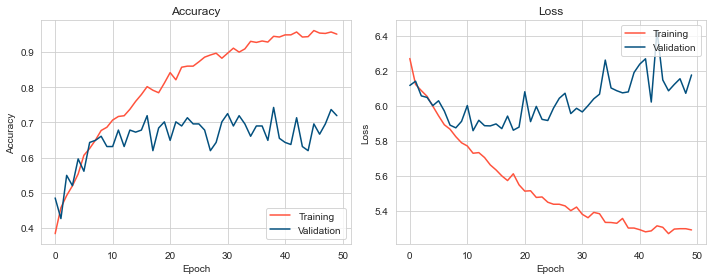

In [60]:
plot_metrics(d2_history)

Best Model:
epoch: 40 , val_accuracy: 0.7485380172729492 , val_loss: 5.825882911682129


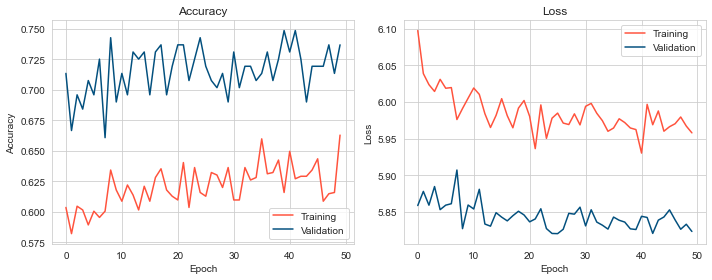

In [61]:
plot_metrics(ft_d2_history)

## Second Run - Metrics

Best Model:
epoch: 39 , val_accuracy: 0.7426900863647461 , val_loss: 6.079125881195068


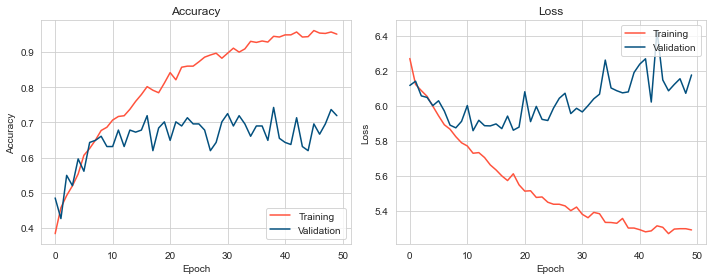

In [62]:
plot_metrics(d2_history)

Best Model:
epoch: 40 , val_accuracy: 0.7485380172729492 , val_loss: 5.825882911682129


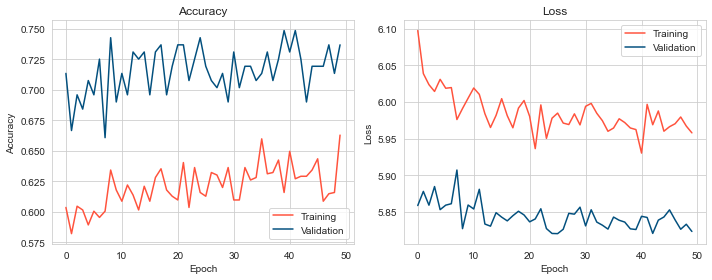

In [63]:
plot_metrics(ft_d2_history)

You can then use keras.models.load_model(filepath) to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [65]:
ft_d2_model2 = load_model('car-damage-dataset/data2a/ft_model.h5')

In [69]:
evaluate_model(ft_d2_model, validation_data_dir, validation_labels)

NameError: name 'evaluate_model' is not defined

# Load Model Point

In [92]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout()
           
    print("Best Model:")
    print_best_model_results(hist)

In [83]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=1,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print()
    print(classification_report(validation_labels, pred_labels))
    print()
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [73]:
ft_model = load_model('car-damage-dataset/data2a/ft_model.h5')

In [75]:
with open('car-damage-dataset/data2a/top_history.txt') as f:    
    top_history = json.load(f)

In [77]:
with open('car-damage-dataset/data2a/history.txt') as f:    
    ft_history = json.load(f)

In [84]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [85]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.

              precision    recall  f1-score   support

           0       0.68      0.90      0.78        73
           1       0.85      0.56      0.67        50
           2       0.78      0.67      0.72        48

    accuracy                           0.74       171
   macro avg       0.77      0.71      0.72       171
weighted avg       0.76      0.74      0.73       171




In [89]:

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

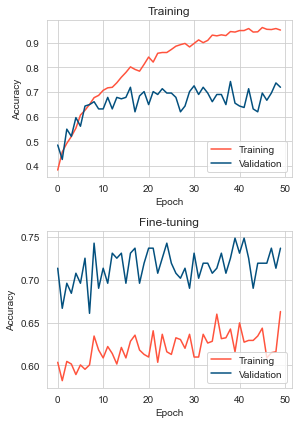

In [90]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 39 , val_accuracy: 0.7426900863647461 , val_loss: 6.079125881195068


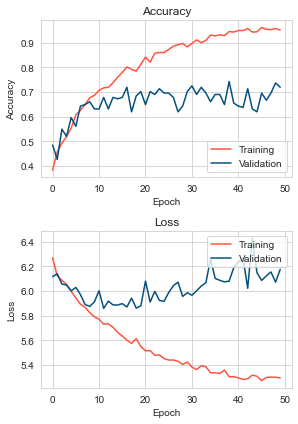

In [93]:
plot_metrics(top_history)

Best Model:
epoch: 40 , val_accuracy: 0.7485380172729492 , val_loss: 5.825882911682129


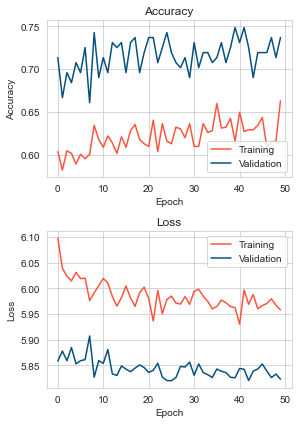

In [94]:
plot_metrics(ft_history)

In [95]:
heatmap_labels = ['Front', 'Rear', 'Side']

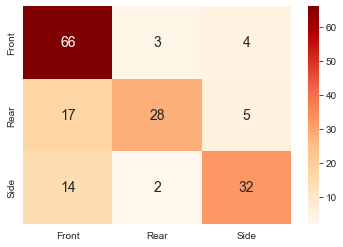

In [96]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

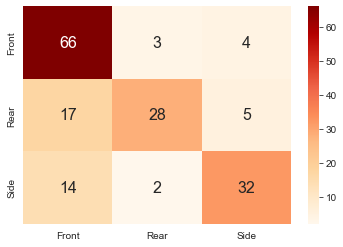

In [97]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

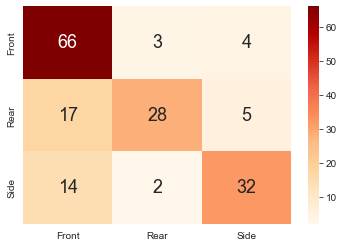

In [98]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

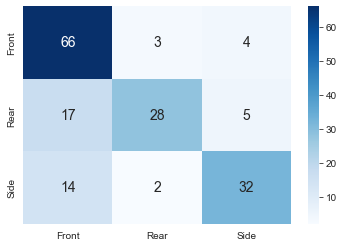

In [99]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

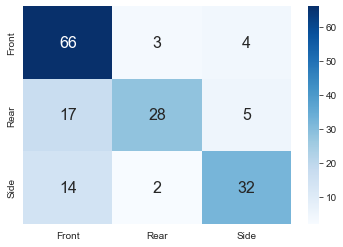

In [100]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

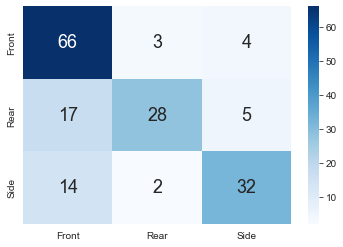

In [101]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Looking at Edge Cases

In [102]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [104]:
front1 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/00-front/', 0, 1) # true front, predicted rear - 8
front2 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/00-front/', 0, 2) # true front, predicted side - 7

In [105]:
rear1 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/01-rear/', 1, 0) # true rear, predicted front - 10
rear2 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/01-rear/', 1, 2) # true rear, predicted side - 5

In [106]:
side1 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/02-side/', 2, 0) # true side, predicted front - 7
side2 = get_edge_cases(ft_model, 'car-damage-dataset/data2a/validation/02-side/', 2, 1) # true side, predicted rear - 4

In [107]:
len(front1) == 8, len(front2) == 7, len(rear1) == 10, len(rear2) == 5, len(side1) == 7, len(side2) == 4

(False, False, False, True, False, False)

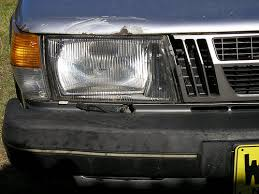

c to continue, q to quitc


In [109]:
view_images('car-damage-dataset/data2a/validation/00-front/', front1)

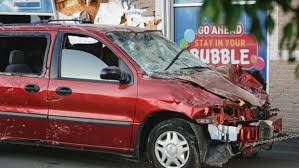

c to continue, q to quitc


In [111]:
view_images('car-damage-dataset/data2a/validation/00-front/', front2)

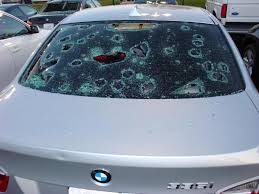

c to continue, q to quitc


In [47]:
view_images('data2a/validation/01-rear/', rear1)

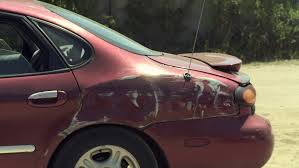

c to continue, q to quitc


In [48]:
view_images('data2a/validation/01-rear/', rear2)

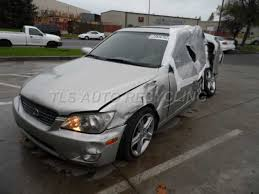

c to continue, q to quitc


In [50]:
view_images('data2a/validation/02-side/', side1)

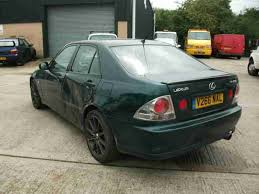

c to continue, q to quitc


In [53]:
view_images('data2a/validation/02-side/', side2)

https://keras.io/visualization/

In [112]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(ft_d2_model2).create(prog='dot', format='svg'))

ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (/Users/bmkim/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/eager/context.py)